In [2]:
import src.results_processing as rp 
import src.threshold_surface_work as surface
import src.layout_templates as templates
from src.CSS_direct import create_CSS_circuit, Hex_Code

import warnings
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
from typing import List
# import sinter
import pickle

In [3]:
layout = templates.diamond(10, noise=0.1*np.ones(5), basis='primary')
hex_code = Hex_Code(layout, 80)

In [4]:
len(hex_code.circuit.shortest_graphlike_error())

10

In [5]:
hex_code.circuit.detector_error_model(decompose_errors=True).num_errors/hex_code.circuit.detector_error_model(decompose_errors=True).num_detectors

15.449193066347878

In [6]:
# hex_code.circuit.diagram(type="match-graph-3d")

In [7]:
import stim

surfcode_circuit = stim.Circuit.generated('surface_code:rotated_memory_x',distance = 10, rounds = 10, after_clifford_depolarization = 0.1)
# surfcode_circuit.diagram(type="match-graph-3d")

In [114]:
surfcode_circuit.detector_error_model(decompose_errors=True).num_errors/surfcode_circuit.detector_error_model(decompose_errors=True).num_detectors

20.69223007063572

## Processing raw qiskit data

The data in the runs/ folder represents the raw readout data from the device. This needs to be processed into syndromes/detectors, then error rates extracted from them. This section is where that is done and then saves the data in the Results/ folder.

In [ ]:
all_runs = rp.list_runs(device=['torino'], size=['2', '3'])
len(all_runs) # Should be 560

320

In [ ]:
# This takes some time ~20min (w/o charge, maybe 10 w/)
all_data = {}

progress = 0
for run in all_runs:
    all_data[run['id']] = rp.process_run(run)
    progress += 1
    if progress % 5 == 0:
        print('.', end='')
        if progress % 100 == 0:
            print(progress)

print(progress)

print(all_data)

....................100
....................200
....................300
....320
{'cnqesvf0k0p00088z9bg': {'date': '20231205', 'device': 'torino', 'size': 2, 'location': 25, 'subrounds': 4, 'basis': 'dual', 'DD': 'False', 'shots': 4096, 'error_rate': 0.3681640625, 'e_likelihood': None, 'm_likelihood': 0.3770751953125}, 'cnqexxfh4w80008vkyf0': {'date': '20231205', 'device': 'torino', 'size': 2, 'location': 63, 'subrounds': 10, 'basis': 'primary', 'DD': 'True', 'shots': 4096, 'error_rate': 0.49267578125, 'e_likelihood': 0.4549967447916667, 'm_likelihood': 0.4586181640625}, 'cnqevb50k0p00088z9w0': {'date': '20231205', 'device': 'torino', 'size': 2, 'location': 63, 'subrounds': 6, 'basis': 'dual', 'DD': 'False', 'shots': 4096, 'error_rate': 0.408447265625, 'e_likelihood': 0.474365234375, 'm_likelihood': 0.36785888671875}, 'cnpy0na24wx0008fd070': {'date': '20231204', 'device': 'torino', 'size': 3, 'location': 25, 'subrounds': 8, 'basis': 'primary', 'DD': 'False', 'shots': 16384, 'error_rate'

In [ ]:
all_data

{'cnqesvf0k0p00088z9bg': {'date': '20231205',
  'device': 'torino',
  'size': 2,
  'location': 25,
  'subrounds': 4,
  'basis': 'dual',
  'DD': 'False',
  'shots': 4096,
  'error_rate': 0.3681640625,
  'e_likelihood': None,
  'm_likelihood': 0.3770751953125},
 'cnqexxfh4w80008vkyf0': {'date': '20231205',
  'device': 'torino',
  'size': 2,
  'location': 63,
  'subrounds': 10,
  'basis': 'primary',
  'DD': 'True',
  'shots': 4096,
  'error_rate': 0.49267578125,
  'e_likelihood': 0.4549967447916667,
  'm_likelihood': 0.4586181640625},
 'cnqevb50k0p00088z9w0': {'date': '20231205',
  'device': 'torino',
  'size': 2,
  'location': 63,
  'subrounds': 6,
  'basis': 'dual',
  'DD': 'False',
  'shots': 4096,
  'error_rate': 0.408447265625,
  'e_likelihood': 0.474365234375,
  'm_likelihood': 0.36785888671875},
 'cnpy0na24wx0008fd070': {'date': '20231204',
  'device': 'torino',
  'size': 3,
  'location': 25,
  'subrounds': 8,
  'basis': 'primary',
  'DD': 'False',
  'shots': 16384,
  'error_rate':

In [ ]:
import json
f = open('Results/first_pass_torino.json', 'w')
json.dump(all_data, f)
f.close()

# Detector Likelihood Threshold

In [141]:
noises = [3.25e-3, 3e-3, 2.75e-3, 2.5e-3, 2.25e-3, 2e-3, 1.75e-3, 1.5e-3, 1.25e-3, 1e-3]
noise_breakdown = np.ones(5)
shots = 2**14
sizes = [14, 11, 8, 5]
distances = []
basis = 'primary'


data = []
for d in range(len(sizes)):
    dats = []
    for n in noises:
        noise = n * np.array(noise_breakdown)
        subrounds = 2 * sizes[d]

        layout = templates.diamond(sizes[d], noise=noise, basis=basis)
        hex_code = Hex_Code(layout, subrounds)

        #error_rate = error_rate_sim(hex_code, shots)
        detectors, logical_ops = hex_code.sample(shots)

        errors = 0
        e_avgs_sum = 0
        for s in range(shots):
            correction = hex_code.match.decode(detectors[s])
            if correction != logical_ops[s]:
                errors += 1
        error_rate = errors / shots

        e_heats, m_heats = rp.get_em_heatmaps(hex_code, detectors,include_spatial_truncs=False,include_timelike_truncs=False)
        e_avg = sum([e_heats[key] for key in e_heats]) / len(e_heats)

        dats.append((e_avg, error_rate))
        print('.', end='')
    distances.append(len(hex_code.circuit.shortest_graphlike_error()))

    data.append(dats)
    print('!', end='')
    print(sizes[d], dats)

print(data)

..........!14 [(0.16135249235192123, 0.16876220703125), (0.15100139695770887, 0.1129150390625), (0.14040869887994262, 0.0731201171875), (0.12928054186762597, 0.03948974609375), (0.11809243961256377, 0.0216064453125), (0.10650173887914541, 0.00958251953125), (0.09464049047353315, 0.00396728515625), (0.08232281743263711, 0.00128173828125), (0.06955827985491071, 0.00042724609375), (0.056492007508569836, 0.0)]
..........!11 [(0.16116248937349345, 0.11798095703125), (0.15070391358094437, 0.08111572265625), (0.14026564080524706, 0.05816650390625), (0.1295156767874053, 0.03497314453125), (0.11790104805602188, 0.020263671875), (0.10644367312596849, 0.011474609375), (0.09429784517314481, 0.006591796875), (0.08218278700983557, 0.00189208984375), (0.06944422025654269, 0.001220703125), (0.056286688350120524, 0.000244140625)]
..........!8 [(0.16084702809651694, 0.078125), (0.15011199315388998, 0.05975341796875), (0.1403473218282064, 0.044189453125), (0.12905009587605795, 0.0301513671875), (0.118287

In [149]:
# f = open("simulation_data/threshold_data_2dsubrounds.obj", 'wb')
# pickle.dump({'data': data,'distances': distances,'sizes': sizes, 'noises':noises ,'shots': shots}, f)
# f.close()

In [136]:
# noises = [5e-3, 4e-3, 3e-3, 2.5e-3, 2e-3, 1.5e-3, 1e-3]
# shots = int(2**17)
# sizes = [14, 11, 8, 5]
# distances = [20, 16, 12, 8]
# basis = 'primary'

# with open(r"simulation_data/threshold_data.obj", "rb") as input_file:
#     data = pickle.load(input_file)

In [148]:
# with open(r"simulation_data/threshold_data_4dsubrounds.obj", "rb") as input_file:
# # with open(r"simulation_data/threshold_data_2dsubrounds.obj", "rb") as input_file:
#     data_dict = pickle.load(input_file)
# data = data_dict['data']
# noises = data_dict['noises']
# sizes = data_dict['sizes']
# distances = sizes#data_dict['distances']
# shots = data_dict['shots']

In [144]:
def fit_func(vars,data,d_list,DLmax):
    pth,PLth = vars
    cost = 0
    for di,d in enumerate(d_list):
        DL_list, PL_list = np.transpose(data[di])
        DL_list, PL_list  =  np.transpose([(DL,PL) for DL,PL in zip(DL_list, PL_list) if DL<DLmax])
        PL_anal = PLth*(DL_list/pth)**int((d+1)/2)
        cost+=np.mean(abs(PL_list-PL_anal)/(PL_list+PL_anal))
    return cost

<Figure size 640x480 with 0 Axes>

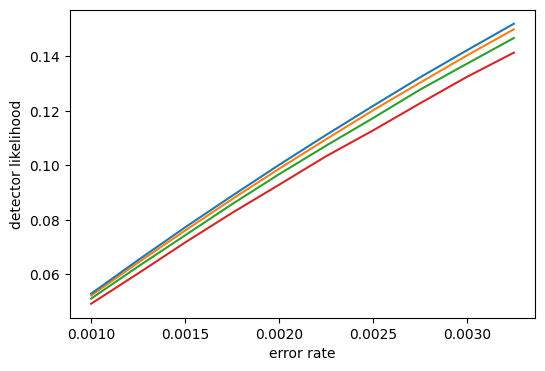

In [153]:
plt.clf()
fig, ax = plt.subplots(1, 1, figsize = (6,4))
for d in range(len(distances)-1,-1,-1):
    dets, _ = np.transpose(data[d])
    plt.plot(noises, dets,'-', color=f'C{d}')
plt.xlabel('error rate')
plt.ylabel('detector likelihood')
plt.show()

In [159]:
DLth

0.10531503487349261

<Figure size 640x480 with 0 Axes>

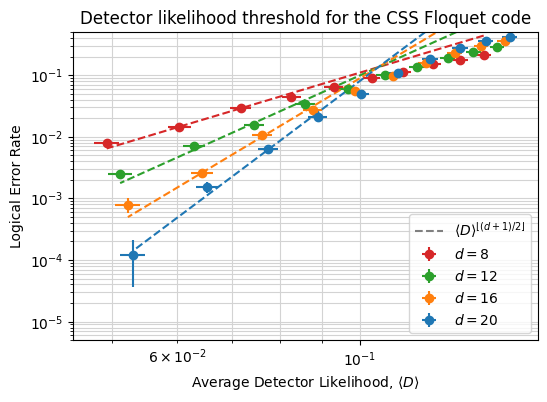

In [158]:
from scipy.optimize import minimize
DLth, PLth = minimize(fit_func,[0.1,0.05], args = (data,distances,0.1), method='Nelder-Mead', tol = 1e-3).x

distances = [20,16,12,8]

plt.clf()
fig, ax = plt.subplots(1, 1, figsize = (6,4))
for d in range(len(distances)-1,-1,-1):
    dets, ers = np.transpose(data[d])
    plt.errorbar(dets, ers, yerr=np.sqrt(ers*shots)/shots, xerr=np.sqrt(dets*shots)/shots, marker = 'o', linestyle=' ', color=f'C{d}',label=f'$d={distances[d]}$')
    plt.plot(dets, PLth*(dets/DLth)**int((distances[d]+1)/2),'--', color=f'C{d}')
ax.loglog()
ax.set_title('Detector likelihood threshold for the CSS Floquet code')
ax.set_xlabel(r"Average Detector Likelihood, $\langle D\rangle$")
ax.set_ylabel("Logical Error Rate")
ax.grid(which='both', color='lightgray')
# if DLth is not None:
#     ax.vlines(DLth, 
#                 1/shots, PLth, 
#                 linestyles='dashed', color='gray', alpha = 0.6,
#                 # label=r'$P_{th}$'f' = {round(100*DLth,2)}%'
#                 )
plt.axhline(1.1,linestyle = '--',c='gray', label = r'$\langle D\rangle^{\lfloor (d+1)/2 \rfloor}$')
ax.set_ylim(5e-6,.5)
# fig.set_dpi(120) 
ax.legend()
# plt.savefig("paper_images/D_threshold_Floquet.pdf")
plt.show()

## Real vs Sim image simulation

In [ ]:
# Select number of sub-rounds (even number between 4 and 16 inclusive, 4 and 10 for Torino data)
num_sub_rounds = 4
assert num_sub_rounds % 2 == 0 and 4 <= num_sub_rounds <= 16, 'Must be even number between 4 and 16 inclusive.'

# Simulation
shots = int(1e5)
noises = [ 1.5e-2, 1.75e-2, 2e-2, 2.25e-2,  2.5e-2, 3e-2, 4e-2, 6e-2]
sizes = [8, 5, 3, 2]
sher_med_noise = [1e-2, 2e-3, 1e-2, 1e-3, 7e-3]
ms = False if num_sub_rounds == 4 else True

e_likelihoods = np.empty((len(sizes),len(noises)))
m_likelihoods = np.empty((len(sizes),len(noises)))
error_rates = np.empty((len(sizes),len(noises)))
for s in range(len(sizes)):
    for n in range(len(noises)):
        # Defining code
        layout = templates.diamond(sizes[s], noise=noises[n]*np.ones(5))
        code = Hex_Code(layout, sub_rounds=num_sub_rounds)

        # Simulating
        detectors, log_ops = code.sample(shots)
        error_rate = error_rate_sim(code, shots)
        
        e_map, m_map = rp.get_em_heatmaps(code, detectors)
        e_avg = sum([e_map[key] for key in e_map]) / len(e_map)
        if ms:
            m_avg = sum([m_map[key] for key in m_map]) / len(m_map)

        # Storing results
        e_likelihoods[s][n] = e_avg
        if ms:
            m_likelihoods[s][n] = m_avg
        error_rates[s][n] = error_rate
        print('.', end='')
    print(',', end='')
error_rates, e_likelihoods

# p_eff fitting 

Simulating different sizes and sub-rounds to get p_eff to average detector likelihood correspondence

In [ ]:
# Defining what to simulate
noises = [5e-2, 4e-2, 3e-2, 2e-2, 1e-2, 6.5e-3, 3.3e-3, 2e-3, 1e-3]
sizes = [11, 8, 5, 3, 2]
sub_rounds = list(np.arange(4,17,2))
shots = int(1e5)

# Simulating data to fit
raw_data_no_spatial_trunce = np.empty((len(sizes), len(sub_rounds), len(noises)))
for size in sizes:
    for srs in sub_rounds:
        for noise in noises:
            # Defining code
            layout = templates.diamond(size, noise=noise*np.ones(5))
            hex_code = Hex_Code(layout, srs)

            # Simulating to get average detector likelihood
            detectors, log_ops = hex_code.sample(shots)
            e_avg_no, m_avg_no = rp.get_em_averages(hex_code, detectors,
                                              include_spatial_truncs=False)

            # Storing data
            raw_data_no_spatial_trunce[sizes.index(size)][sub_rounds.index(srs)][noises.index(noise)] = e_avg_no
            print('.', end='')
        print(',', end='')
    print('!', size)
print('Done.')

In [18]:
# Defining what to simulate
noises = [5e-2, 4e-2, 3e-2, 2e-2, 1e-2, 6.5e-3, 3.3e-3, 2e-3, 1e-3]
sizes = [11, 8, 5, 3, 2]
shots = int(1e4)

# Simulating data to fit
raw_data_no_spatial_trunce = np.empty((len(sizes), len(sub_rounds), len(noises)))
for size in sizes:
    for noise in noises:
        # Defining code
        layout = templates.diamond(size, noise=noise*np.ones(5))
        hex_code = Hex_Code(layout, 22)

        # Simulating to get average detector likelihood
        detectors, log_ops = hex_code.sample(shots)
        e_avg_no, m_avg_no = rp.get_em_averages(hex_code, detectors,
                                            include_spatial_truncs=False)

        # Storing data
        raw_data_no_spatial_trunce[sizes.index(size)][sub_rounds.index(srs)][noises.index(noise)] = e_avg_no
        print('.', end='')
    print('!', size)
print('Done.')

KeyboardInterrupt: 

In [15]:
raw_data_no_spatial_trunce[-1][0]

array([0.4906, 0.5036, 0.4737, 0.4472, 0.3378, 0.261 , 0.1612, 0.0994,
       0.0508])

In [15]:
f = open("simulation_data/p_eff_fitting_data.obj", "wb")
pickle.dump(raw_data_no_spatial_trunce, f)
f.close()

## Group By config to get logical error rate per round

# Threshold Surface Simulation

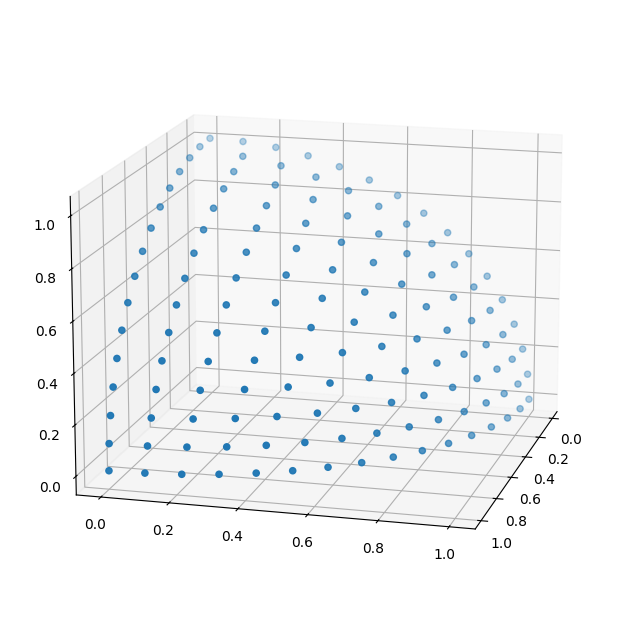

In [191]:
granularity = 15

thetas = np.linspace(0, np.pi/2, granularity + 1)
noise_bdowns = []
points = []
for g in range(granularity + 1):
    phis = np.linspace(0, np.pi/2, granularity + 1 - g)
    for phi in phis:
        x, y, z = np.cos(thetas[g])*np.sin(phi), np.cos(thetas[g])*np.cos(phi), np.sin(thetas[g])
        noises = [z, x, z, 1e-4, y]
        noise_bdowns.append(noises)

figsize = (8, 8)

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(projection='3d')

xs = [n[1] for n in noise_bdowns]
ys = [n[4] for n in noise_bdowns]
zs = [n[0] for n in noise_bdowns]
cs = [str(q%7) for q in range(len(zs))]
cmap = colormaps['viridis']
ax.scatter(xs, ys, zs, 'o')#, color=[cmap(5 * h) for h in e_avgs])
#ax.scatter()


ax.view_init(15,15)
plt.show()

In [173]:
# noise_bdowns = [[1.,1.,1.,1.,1.]/np.sqrt(5)]
# noise_bdowns = [[0.00000000e+00, 8.66025399e-01, 0.00000000e+00, 9.99999995e-05, 4.99999998e-01]]

In [193]:
thresholds = [surface.varying_error_rate_sim(noise_breakdown=np.array(nb), 
                                             printing=True, 
                                             plotting=False,
                                             first_noises=[3e-3, 6e-3, 1e-2, 2e-2, 3e-2, 5e-2],
                                             second_slices=5,
                                             variable_sub_rounds=True)
              for nb in noise_bdowns]

Noise breakdown: [0.e+00 0.e+00 0.e+00 1.e-04 1.e+00]......first_thresh: 0.009315315315315315;.....threshold:0.008380131633134637
Noise breakdown: [0.00000000e+00 1.04528463e-01 0.00000000e+00 1.00000000e-04
 9.94521895e-01]......first_thresh: 0.006832832832832833;.....threshold:0.007869613190100343
Noise breakdown: [0.00000000e+00 2.07911691e-01 0.00000000e+00 1.00000000e-04
 9.78147601e-01]......first_thresh: 0.006912912912912913;.....threshold:0.007608644430216003
Noise breakdown: [0.00000000e+00 3.09016994e-01 0.00000000e+00 1.00000000e-04
 9.51056516e-01]......first_thresh: 0.0065965965965965965;.....threshold:0.00694271431925753
Noise breakdown: [0.00000000e+00 4.06736643e-01 0.00000000e+00 1.00000000e-04
 9.13545458e-01]......first_thresh: 0.006248248248248248;.....threshold:0.006821056458527264
Noise breakdown: [0.00000000e+00 5.00000000e-01 0.00000000e+00 1.00000000e-04
 8.66025404e-01]......first_thresh: 0.006576576576576577;.....threshold:0.006763922330739147
Noise breakdown

In [211]:
fail_inds = [i for i,t in enumerate(thresholds) if t[0]==-1]
noise_bdowns_vol2 = [noise_bdowns[i] for i in fail_inds]

[[0.40673664307580015,
  0.5982450488842149,
  0.40673664307580015,
  0.0001,
  0.6904115907666617],
 [0.5877852522924731,
  0.27670010836902126,
  0.5877852522924731,
  0.0001,
  0.760227299704533],
 [0.6691306063588581,
  0.14498036330700428,
  0.6691306063588581,
  0.0001,
  0.7288655060360559]]

Noise breakdown: [4.06736643e-01 5.98245049e-01 4.06736643e-01 1.00000000e-04
 6.90411591e-01]......

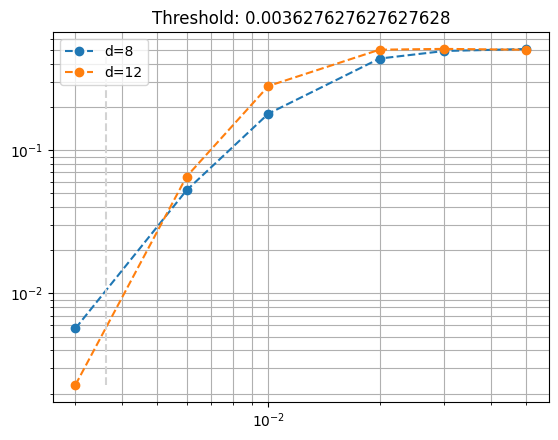

first_thresh: 0.003627627627627628;.....threshold:0.005032168304440577


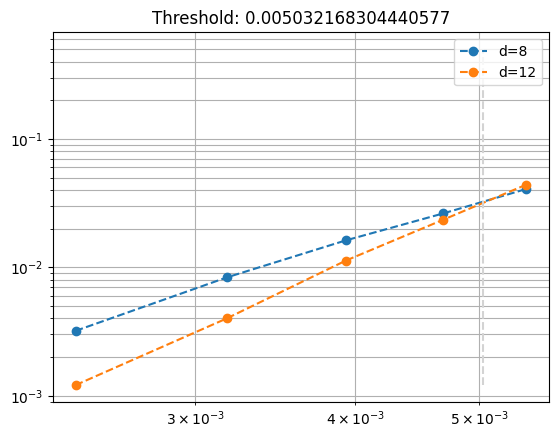

Noise breakdown: [5.87785252e-01 2.76700108e-01 5.87785252e-01 1.00000000e-04
 7.60227300e-01]......

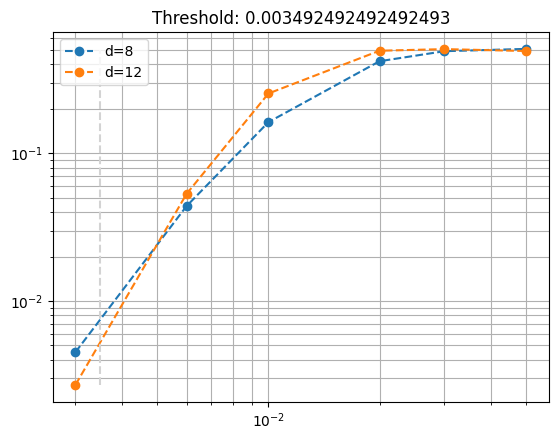

first_thresh: 0.003492492492492493;.....threshold:0.005195038882726571


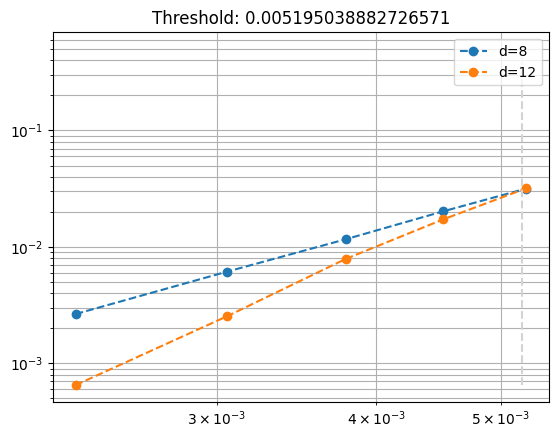

Noise breakdown: [6.69130606e-01 1.44980363e-01 6.69130606e-01 1.00000000e-04
 7.28865506e-01]......

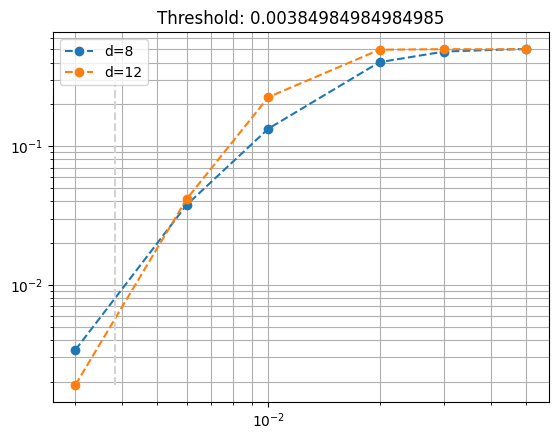

first_thresh: 0.00384984984984985;.....threshold:0.0053829815801787785


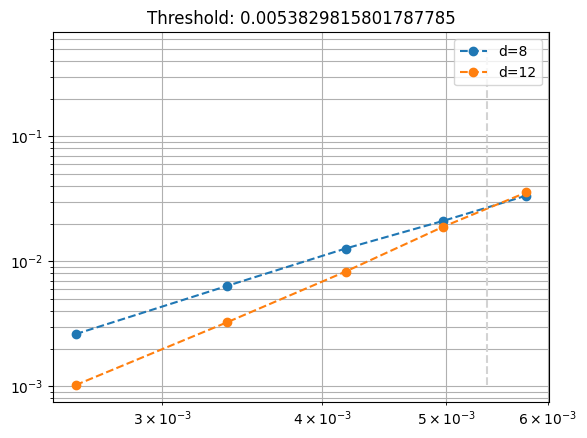

In [212]:
fail_inds = [i for i,t in enumerate(thresholds) if t[0]==-1]
noise_bdowns_vol2 = [noise_bdowns[i] for i in fail_inds]

thresholds_vol2 = [surface.varying_error_rate_sim(noise_breakdown=np.array(nb), 
                                             printing=True, 
                                             plotting=True,
                                             first_noises=[3e-3, 6e-3, 1e-2, 2e-2, 3e-2, 5e-2],
                                             second_slices=5,
                                             variable_sub_rounds=True)
              for nb in noise_bdowns_vol2]

In [214]:
for ind, th in zip(fail_inds,thresholds_vol2):
    thresholds[ind] = th

In [215]:
thresholds = [t[0] for t in thresholds]

threshold_points = []
for t in range(len(thresholds)):
    threshold = thresholds[t]
    noise = noise_bdowns[t]
    x = noise[1] * threshold
    y = noise[4] * threshold
    z = noise[0] * threshold
    threshold_points.append((x, y, z))

In [216]:
threshold_points

[(0.0, 0.008380131633134637, 0.0),
 (0.0008225985732720449, 0.007826502625633756, 0.0),
 (0.0015819261283173361, 0.007442377294252418, 0.0),
 (0.002145416711740871, 0.006602913694105545, 0.0),
 (0.002774373606171885, 0.006231345144011307, 0.0),
 (0.0033819611653695732, 0.005857728567644952, 0.0),
 (0.004083273797861501, 0.005620144231710236, 0.0),
 (0.004537880994065161, 0.005039827422814307, 0.0),
 (0.005290323756351498, 0.004763428905863831, 0.0),
 (0.005699772135977073, 0.0041411268567272995, 0.0),
 (0.006304945633896072, 0.003640162058955854, 0.0),
 (0.006919089257070275, 0.0030805770134578157, 0.0),
 (0.007707211182206179, 0.002504224716125291, 0.0),
 (0.008638992260186523, 0.0018362744911191817, 0.0),
 (0.009525716485956567, 0.0010011931466141137, 0.0),
 (0.011334617901184469, 6.9404517661219255e-19, 0.0),
 (0.0, 0.007604906245938035, 0.0007993078552464835),
 (0.0007569440085631207, 0.006718063886805306, 0.00071056484992218),
 (0.0014710992057936107, 0.006445306748524932, 0.00069

In [217]:
import json

threshold_data = {'data': threshold_points}

f = open('simulation_data/threshold_surface_thresholds_g=15_nofail.json', 'w')
json.dump(threshold_data, f)
f.close()